In [58]:
# -*- coding: utf-8 -*-
"""
Created on Tue Dec 24 02:24:12 2019

@author: Admin
"""

import pandas as pd
import numpy as np

from scipy.signal import savgol_filter, argrelextrema
import openpyxl

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn import datasets

import pickle
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix

import warnings,os
warnings.simplefilter('ignore')

import matplotlib as mpl
import matplotlib.dates as mdates
import datetime as dt
import csv

import seaborn as sns
import matplotlib.pyplot as plt

from pylab import rcParams

path="C:\\Users\\Admin\\Documents\\"

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [59]:
def CreateData(dataFrame):
    print(dataFrame.shape)
    dataset =np.array( dataFrame.iloc[:, 0:dataFrame.shape[1]-1])
    target = dataFrame.iloc[:,dataFrame.shape[1]-1:dataFrame.shape[1]]
    target = np.array(target.replace(to_replace=['О', 'К'], value=[1, 0]))
    target =target.astype('int32')   
    target.transpose()
    return dataset,target

In [60]:
#сохранение
def saveModel(score,path,nameModel):
    save=False
    dateFile = os.listdir(path)
    name=path+ str(score)+'_'+nameModel+'.pkl'
    for item in dateFile:
        temp=item.split('_')
        if len(temp)==2:
            if (temp[1].find(nameModel)!=-1):
                if (float(temp[0])<score):
                    print("Модель",nameModel,"сохранена\n")
                    save=True
                break
    else:
        save=True
    return save,name

In [61]:
# path="C:\\Users\\admin\\Downloads\\Telegram Desktop\\new_sav_filter_data_scaled.xlsx"
name = "sav_filter_data_scaled__5_2.xlsx"
path="C:\\Users\\admin\\Documents\\PythonRamanCopy\\"+name
dataFrame = pd.read_excel(path)
clear_data, target=CreateData(dataFrame)
target = target.ravel()

(980, 655)


# Блок отбора признаков

In [62]:
"""пока пусто"""
# from sklearn.feature_selection import RFE
# from sklearn.ensemble import ExtraTreesClassifier

'пока пусто'

Best parameter (CV score=0.585):
{'logistic__C': 21.54434690031882, 'logistic__n_jobs': -1, 'logistic__penalty': 'l2', 'pca__n_components': 7}


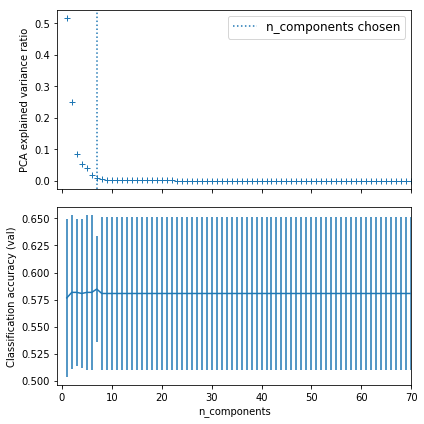

PCA(copy=True, iterated_power='auto', n_components=7, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)


In [63]:
pca = PCA()
# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [item for item in range(1,100,1)],
    'logistic__C': np.logspace(-4, 4, 4),
    'logistic__penalty': ['l2'],
    'logistic__n_jobs': [-1]
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(clear_data, target)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# Plot the PCA spectrum
pca.fit(clear_data)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.xlim(-1, 70)

plt.tight_layout()
plt.show()

pca_2 = PCA(n_components =search.best_estimator_.named_steps['pca'].n_components).fit(clear_data)
print(pca_2)
clear_data_out = pca_2.transform(clear_data)

# Анализ новой выборки

https://pandas.pydata.org/docs/reference/api/pandas.plotting.scatter_matrix.html

,0,1,2,3,4,5,6
0,1.000000e+00,-4.145253e-17,-4.370266e-16,-2.089792e-16,3.943794e-16,-1.610086e-16,-4.846669e-16
1,-4.145253e-17,1.000000e+00,-9.963620e-15,1.999844e-16,2.634985e-16,-1.467210e-15,5.400403e-18
2,-4.370266e-16,-9.963620e-15,1.000000e+00,6.759567e-17,-6.177982e-18,3.037751e-16,5.718219e-16
3,-2.089792e-16,1.999844e-16,6.759567e-17,1.000000e+00,-3.066923e-16,7.313225e-16,5.466137e-16
4,3.943794e-16,2.634985e-16,-6.177982e-18,-3.066923e-16,1.000000e+00,-6.079427e-17,2.850242e-16
5,-1.610086e-16,-1.467210e-15,3.037751e-16,7.313225e-16,-6.079427e-17,1.000000e+00,-8.773579e-17
6,-4.846669e-16,5.400403e-18,5.718219e-16,5.466137e-16,2.850242e-16,-8.773579e-17,1.000000e+00


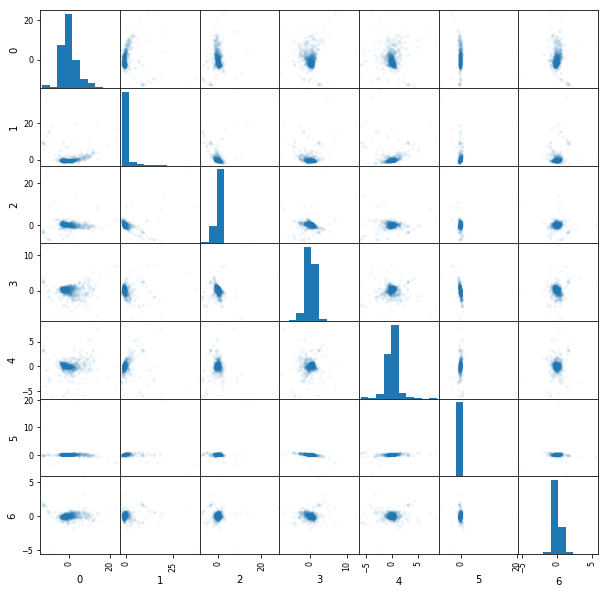

In [64]:
from pandas.tools.plotting import scatter_matrix
pd_clear_data_out = pd.DataFrame(data=clear_data_out[0:,0:],    # values
              index=range(0, len(clear_data_out)),    # 1st column as index
              columns=range(0, len(clear_data_out[0])))
                                 
scatter_matrix(pd_clear_data_out, alpha=0.05, figsize=(10, 10))
pd_clear_data_out.corr()

# Используем все данные в обучающей выборке

Чтоб не переписывать код присвоим переменным normalized_test_dataset, test_target значения всей выборки

In [65]:
normalized_train_dataset = clear_data_out
train_target = target

normalized_test_dataset = clear_data_out
test_target = target

spec=[]
ch=[]
Score=[]

In [66]:
all_models = {
    'lgModel':None,
    'sgv_classifier':None,
    'linear_svc':None,
    'nu_svc':None,
    'k_neighbors':None,
    'rdf_model':None,
}

# Логическая регрессия
LogisticRegression
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Логическая регрессия

0.40714285714285714 0.0001 

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.55      0.46      0.50       444
           1       0.61      0.69      0.65       536

   micro avg       0.59      0.59      0.59       980
   macro avg       0.58      0.58      0.57       980
weighted avg       0.58      0.59      0.58       980

Точноть 0.5867346938775511
Специфичность 0.46396396396396394
Чувствительность 0.6884328358208955
--------------
f1ScoreWeighted= 0.5816130825926878
f1ScoreMacro= 0.5749766285334285
f1ScoreBinary= 0.6456692913385828


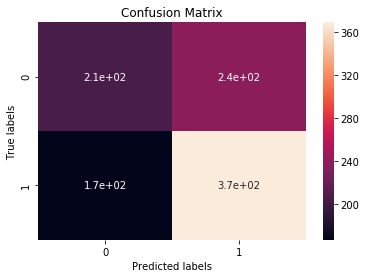

In [67]:
from sklearn.linear_model import LogisticRegression
#Логическая регрессия
print("Логическая регрессия\n")

#GridSearchCV
tuned_parameters = {'C': np.logspace(-4, 4, 4),
                    'penalty': ['l2'],
                    'n_jobs': [-1]}
grid = GridSearchCV(LogisticRegression(solver='liblinear'), tuned_parameters, 
                   cv=5, scoring="accuracy")
grid.fit(normalized_train_dataset, train_target)

best_cv_err2 = 1 - grid.best_score_
best_parameter = grid.best_estimator_.C
print (best_cv_err2, best_parameter,"\n")

#Обучение модели с оптимальными параметрами
all_models['lgModel'] = LogisticRegression(C=grid.best_estimator_.C,
                            penalty=grid.best_estimator_.penalty,
                             n_jobs=grid.best_estimator_.n_jobs,
                            )
print(all_models['lgModel'])
print('--------------------------------------------------------')
all_models['lgModel'].fit(normalized_train_dataset, train_target)

expected = test_target
predicted = all_models['lgModel'].predict(normalized_test_dataset)

#Отрисовка confusion_matrix
cm = metrics.confusion_matrix(expected, predicted)

spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
buff_score=all_models['lgModel'].score(normalized_test_dataset, test_target)

print(metrics.classification_report(expected, predicted))

print('Точноть',buff_score)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')  

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(['К', 'О']); 
# ax.xaxis.set_ticklabels(['К', 'О']); 

f1ScoreWeighted=f1_score(test_target, predicted, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(test_target, predicted, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)

f1ScoreBinary=f1_score(test_target, predicted, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)

Score.append(buff_score)


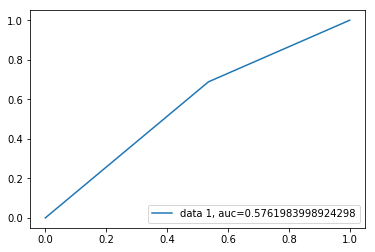

In [68]:
fpr, tpr, _ = metrics.roc_curve(expected,  predicted)
auc = metrics.roc_auc_score(expected, predicted)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# Stochastic Gradient Descent
Stochastic Gradient Descent

Документация:
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier

доп инфо:
https://scikit-learn.org/stable/modules/sgd.html

Stochastic Gradient Descent


            best_parameter_alpha: 0.0001
 
            best_parameter_n_iter: 1000

            best_parameter_loss: log
 
            best_parameter_penalty: elasticnet
 
            best_parameter_n_jobs: -1

        
---------------------------------------------------------------
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='elasticnet',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
              precision    recall  f1-score   support

           0       0.63      0.16      0.26       444
           1       0.57      0.92      0.71       536

   micro avg       0.58      0.58      0.58       980
   macro avg       0.60      0.54      0.48       980
weighted 

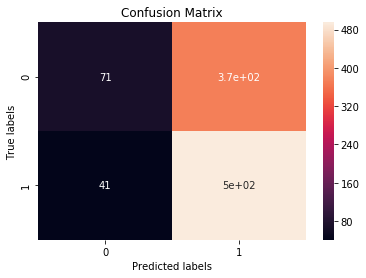

In [69]:
from sklearn.linear_model import SGDClassifier
#Stochastic Gradient Descent
print("Stochastic Gradient Descent\n")

#GridSearchCV
tuned_parameters = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'n_iter': [1000], # number of epochs
    'loss': ['log', 
             'hinge', 
             'modified_huber', 
             'squared_hinge', 
             'perceptron',
             'squared_loss',
              'epsilon_insensitive',
            ], # logistic regression,
    'penalty': ['l2','l1', 'elasticnet'],
    'n_jobs': [-1]
}
grid = GridSearchCV(SGDClassifier(), tuned_parameters, 
                   cv=5, scoring="accuracy")
grid.fit(normalized_train_dataset, train_target)

best_cv_err2 = 1 - grid.best_score_
best_parameter_alpha = grid.best_estimator_.alpha
best_parameter_n_iter = grid.best_estimator_.n_iter
best_parameter_loss = grid.best_estimator_.loss
best_parameter_penalty = grid.best_estimator_.penalty
best_parameter_n_jobs = grid.best_estimator_.n_jobs
print ("""
            best_parameter_alpha: {best_parameter_alpha}\n 
            best_parameter_n_iter: {best_parameter_n_iter}\n
            best_parameter_loss: {best_parameter_loss}\n 
            best_parameter_penalty: {best_parameter_penalty}\n 
            best_parameter_n_jobs: {best_parameter_n_jobs}\n
        """.format(
                best_parameter_alpha= best_parameter_alpha, 
                best_parameter_n_iter= best_parameter_n_iter, 
                best_parameter_loss= best_parameter_loss, 
                best_parameter_penalty= best_parameter_penalty, 
                best_parameter_n_jobs= best_parameter_n_jobs, 
    ))


#Обучение модели с оптимальными параметрами
all_models['sgv_classifier'] = SGDClassifier(alpha= best_parameter_alpha, 
        n_iter= best_parameter_n_iter, 
        loss= best_parameter_loss, 
        penalty= best_parameter_penalty, 
        n_jobs= best_parameter_n_jobs)
print('---------------------------------------------------------------')
print(all_models['sgv_classifier'])
all_models['sgv_classifier'].fit(normalized_train_dataset, train_target)

expected = test_target
predicted = all_models['sgv_classifier'].predict(normalized_test_dataset)

#Отрисовка confusion_matrix
cm = metrics.confusion_matrix(expected, predicted)

spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
buff_score=all_models['sgv_classifier'].score(normalized_test_dataset, test_target)

print(metrics.classification_report(expected, predicted))

print('Точноть',buff_score)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')  

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

f1ScoreWeighted=f1_score(test_target, predicted, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(test_target, predicted, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)

f1ScoreBinary=f1_score(test_target, predicted, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)


Score.append(buff_score)

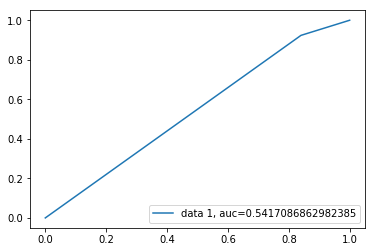

In [70]:
fpr, tpr, _ = metrics.roc_curve(expected,  predicted)
auc = metrics.roc_auc_score(expected, predicted)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# LinearSVC


            best_cv_err2: 0.43061224489795913

            C: 1
 
        
LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
              precision    recall  f1-score   support

           0       0.59      0.31      0.41       444
           1       0.59      0.82      0.69       536

   micro avg       0.59      0.59      0.59       980
   macro avg       0.59      0.57      0.55       980
weighted avg       0.59      0.59      0.56       980

Точноть 0.5908163265306122
Специфичность 0.3130630630630631
Чувствительность 0.8208955223880597
--------------
f1ScoreWeighted= 0.5612217469619007
f1ScoreMacro= 0.5481944679173005
f1ScoreBinary= 0.6869633099141297


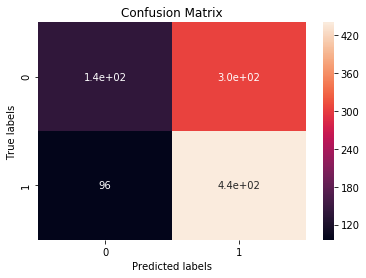

In [71]:
from sklearn.svm import LinearSVC
#LinearSVC

#GridSearchCV

tuned_parameters = {'C': [1, 10, 100, 1000]}

grid = GridSearchCV(LinearSVC(), tuned_parameters, 
                   cv=5, scoring="accuracy")

grid.fit(normalized_train_dataset, train_target)

best_cv_err2 = 1 - grid.best_score_
C = grid.best_estimator_.C
print ("""
            best_cv_err2: {best_cv_err2}\n
            C: {C}\n 
        """.format(
                best_cv_err2= best_cv_err2, 
                C= C, 
    ))


#Обучение модели с оптимальными параметрами
all_models['linear_svc'] = LinearSVC(C= C)
print(all_models['linear_svc'])
all_models['linear_svc'].fit(normalized_train_dataset, train_target)

expected = test_target
predicted = all_models['linear_svc'].predict(normalized_test_dataset)
predicted_sgv_classifier=predicted

#Отрисовка confusion_matrix
cm = metrics.confusion_matrix(expected, predicted)

spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
buff_score=all_models['linear_svc'].score(normalized_test_dataset, test_target)

print(metrics.classification_report(expected, predicted))

print('Точноть',buff_score)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')  

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

f1ScoreWeighted=f1_score(test_target, predicted, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(test_target, predicted, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)

f1ScoreBinary=f1_score(test_target, predicted, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)


Score.append(buff_score)

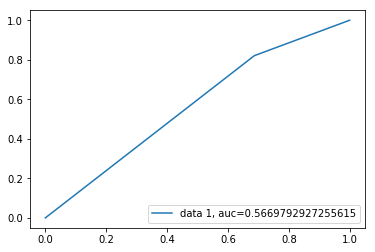

In [72]:
fpr, tpr, _ = metrics.roc_curve(expected,  predicted)
auc = metrics.roc_auc_score(expected, predicted)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# Nu-Support Vector Classification
Similar to SVC but uses a parameter to control the number of support vectors.

The implementation is based on libsvm.
https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVC.html


            best_cv_err2: 0.42551020408163265

            kernel: linear

            nu: 0.6000000000000001
 
        
NuSVC(cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
   kernel='linear', max_iter=-1, nu=0.6000000000000001, probability=True,
   random_state=None, shrinking=True, tol=0.001, verbose=False)
              precision    recall  f1-score   support

           0       0.45      0.89      0.60       444
           1       0.51      0.09      0.15       536

   micro avg       0.45      0.45      0.45       980
   macro avg       0.48      0.49      0.37       980
weighted avg       0.48      0.45      0.35       980

Точноть 0.45408163265306123
Специфичность 0.8941441441441441
Чувствительность 0.08955223880597014
--------------
f1ScoreWeighted= 0.35388863218442246
f1ScoreMacro= 0.37479057332527227
f1ScoreBinary= 0.15213946117274166


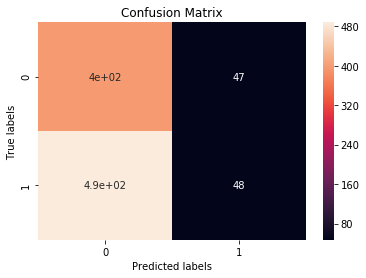

In [73]:
from sklearn.svm import NuSVC
#LinearSVC

#GridSearchCV

tuned_parameters = {'nu':np.arange(.05,0.95,0.05),
                    'kernel': ['linear']
                   }

grid = GridSearchCV(NuSVC(), tuned_parameters, 
                   cv=5, scoring="accuracy")

grid.fit(normalized_train_dataset, train_target)

best_cv_err2 = 1 - grid.best_score_
kernel = grid.best_estimator_.kernel
nu = grid.best_estimator_.nu
print ("""
            best_cv_err2: {best_cv_err2}\n
            kernel: {kernel}\n
            nu: {nu}\n 
        """.format(
                best_cv_err2= best_cv_err2, 
                kernel= kernel, 
                nu= nu, 
    ))


#Обучение модели с оптимальными параметрами
all_models['nu_svc'] = NuSVC(kernel= kernel,nu=nu,probability=True)
print(all_models['nu_svc'])
all_models['nu_svc'].fit(normalized_train_dataset, train_target)

expected = test_target
predicted = all_models['nu_svc'].predict(normalized_test_dataset)
predicted_sgv_classifier=predicted

#Отрисовка confusion_matrix
cm = metrics.confusion_matrix(expected, predicted)

spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
buff_score=all_models['nu_svc'].score(normalized_test_dataset, test_target)

print(metrics.classification_report(expected, predicted))

print('Точноть',buff_score)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')  

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

f1ScoreWeighted=f1_score(test_target, predicted, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(test_target, predicted, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)

f1ScoreBinary=f1_score(test_target, predicted, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)


Score.append(buff_score)

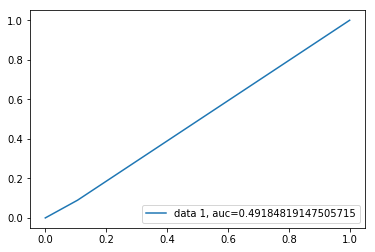

In [74]:
fpr, tpr, _ = metrics.roc_curve(expected,  predicted)
auc = metrics.roc_auc_score(expected, predicted)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# Создание модели КNN


            best_cv_err2: 0.41836734693877553

            n_neighbors: 99
 
        
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=99, p=2,
           weights='uniform')
              precision    recall  f1-score   support

           0       0.68      0.26      0.38       444
           1       0.60      0.90      0.72       536

   micro avg       0.61      0.61      0.61       980
   macro avg       0.64      0.58      0.55       980
weighted avg       0.63      0.61      0.56       980

Точноть 0.610204081632653
Специфичность 0.2635135135135135
Чувствительность 0.8973880597014925
--------------
f1ScoreWeighted= 0.5635888771092853
f1ScoreMacro= 0.5478219696969697
f1ScoreBinary= 0.7157738095238095


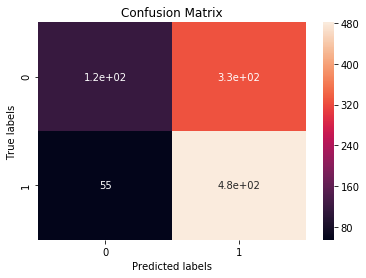

In [75]:
from sklearn.neighbors import KNeighborsClassifier

tuned_parameters = {'n_neighbors': list(range(1,100))}

grid = GridSearchCV(KNeighborsClassifier(), tuned_parameters, 
                   cv=5, scoring="accuracy")

grid.fit(normalized_train_dataset, train_target)

best_cv_err2 = 1 - grid.best_score_
n_neighbors = grid.best_estimator_.n_neighbors
print ("""
            best_cv_err2: {best_cv_err2}\n
            n_neighbors: {n_neighbors}\n 
        """.format(
                best_cv_err2= best_cv_err2, 
                n_neighbors= n_neighbors, 
    ))


#Обучение модели с оптимальными параметрами
all_models['k_neighbors'] = KNeighborsClassifier(n_neighbors = n_neighbors)
print(all_models['k_neighbors'])
all_models['k_neighbors'].fit(normalized_train_dataset, train_target)

expected = test_target
predicted = all_models['k_neighbors'].predict(normalized_test_dataset)

#Отрисовка confusion_matrix
cm = metrics.confusion_matrix(expected, predicted)

spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
buff_score=all_models['k_neighbors'].score(normalized_test_dataset, test_target)

print(metrics.classification_report(expected, predicted))

print('Точноть',buff_score)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')  

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

f1ScoreWeighted=f1_score(test_target, predicted, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(test_target, predicted, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)

f1ScoreBinary=f1_score(test_target, predicted, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)


Score.append(buff_score)

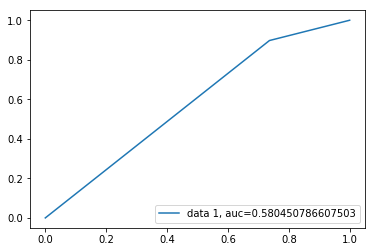

In [76]:
fpr, tpr, _ = metrics.roc_curve(expected,  predicted)
auc = metrics.roc_auc_score(expected, predicted)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# Случайный лес


            n_estimators: 55

            max_features: sqrt
 
        
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=55, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       444
           1       1.00      1.00      1.00       536

   micro avg       1.00      1.00      1.00       980
   macro avg       1.00      1.00      1.00       980
weighted avg       1.00      1.00      1.00       980

Точноть 0.9979591836734694
Специфичность 0.9977477477477478
Чувствительность 0.9981343283582089
--------------
f1ScoreWeighted= 0.9979591836734694
f1ScoreMacro= 0.9979410380529783
f1ScoreBina

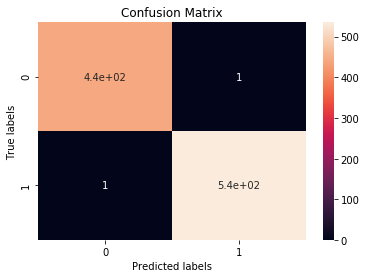

In [77]:
from sklearn.ensemble import RandomForestClassifier

tuned_parameters = {'n_estimators': np.arange(10,100),'max_features': ['auto', 'sqrt', 'log2']}

rdf = RandomForestClassifier(n_jobs=-1, oob_score = True) 

grid = GridSearchCV(rdf, tuned_parameters, 
                   cv=5, scoring="accuracy")

grid.fit(normalized_train_dataset, train_target)

best_cv_err2 = 1 - grid.best_score_
n_estimators = grid.best_estimator_.n_estimators
max_features = grid.best_estimator_.max_features
print ("""
            n_estimators: {n_estimators}\n
            max_features: {max_features}\n 
        """.format(
                best_cv_err2= best_cv_err2, 
                n_estimators= n_estimators, 
                max_features= max_features, 
    ))


#Обучение модели с оптимальными параметрами
all_models['rdf_model'] = RandomForestClassifier(n_estimators = n_estimators,
                                   max_features=max_features,
                                   n_jobs=-1, 
                                   oob_score = True
                                  )
print(all_models['rdf_model'])
all_models['rdf_model'].fit(normalized_train_dataset, train_target)

expected = test_target
predicted = all_models['rdf_model'].predict(normalized_test_dataset)
predicted_sgv_classifier=predicted

#Отрисовка confusion_matrix
cm = metrics.confusion_matrix(expected, predicted)

spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
buff_score=all_models['rdf_model'].score(normalized_test_dataset, test_target)

print(metrics.classification_report(expected, predicted))

print('Точноть',buff_score)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')  

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

f1ScoreWeighted=f1_score(test_target, predicted, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(test_target, predicted, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)

f1ScoreBinary=f1_score(test_target, predicted, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)


Score.append(buff_score)

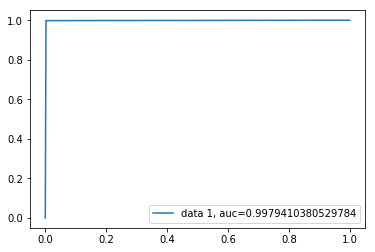

In [78]:
fpr, tpr, _ = metrics.roc_curve(expected,  predicted)
auc = metrics.roc_auc_score(expected, predicted)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# Оценка обученных классификаторов 

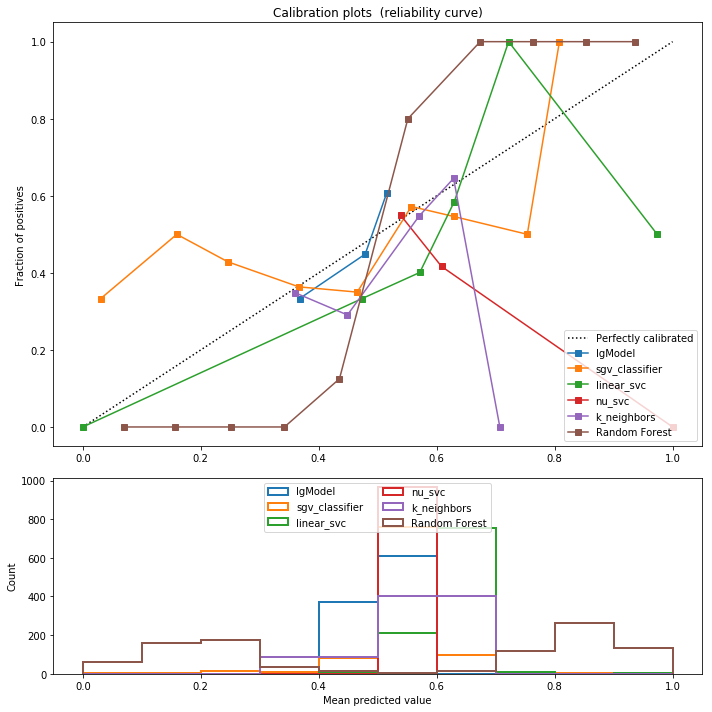

In [79]:
np.random.seed(0)

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.calibration import calibration_curve

# #############################################################################
# Plot calibration plots

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(all_models['lgModel'], 'lgModel'),
                  (all_models['sgv_classifier'], 'sgv_classifier'),
                  (all_models['linear_svc'], 'linear_svc'),
                  (all_models['nu_svc'], 'nu_svc'),
                  (all_models['k_neighbors'], 'k_neighbors'),
                  (all_models['rdf_model'], 'Random Forest'),
                 ]:
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(normalized_test_dataset)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(normalized_test_dataset)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(test_target, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

# Взвешенное голосование 'hard'

0.8938775510204081
0.8938775510204081
[[426  18]
 [ 86 450]]
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       444
           1       0.96      0.84      0.90       536

   micro avg       0.89      0.89      0.89       980
   macro avg       0.90      0.90      0.89       980
weighted avg       0.90      0.89      0.89       980

Точноть 0.8938775510204081
Специфичность 0.9594594594594594
Чувствительность 0.8395522388059702
------------------------
f1ScoreWeighted= 0.8940579922645683
f1ScoreMacro= 0.8938138658754106
f1ScoreBinary= 0.8964143426294822


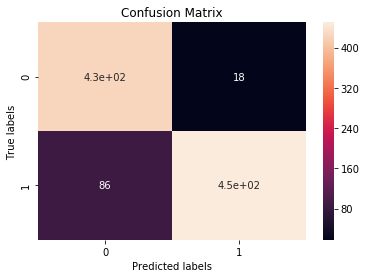

In [80]:
eclf1 = VotingClassifier(estimators=[('rdf_model',all_models['rdf_model']),
                                     ('linear_svc', all_models['linear_svc']), 
                                     ('nu_svc', all_models['nu_svc']),
                                        ], 
                                     voting='hard')
eclf1 = eclf1.fit(normalized_train_dataset, train_target)

print(eclf1.score( normalized_train_dataset, train_target))

print(eclf1.score( normalized_test_dataset, test_target))

expected = test_target
predicted_VotingClassifier = eclf1.predict(normalized_test_dataset)

#---------------------------------------------------------------------
#Отрисовка confusion_matrix

cm = metrics.confusion_matrix(expected, predicted_VotingClassifier)
print(cm)
spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
buff_score=eclf1.score(normalized_test_dataset, test_target)
Score.append(buff_score)
print(metrics.classification_report(expected, predicted_VotingClassifier))
print('Точноть',buff_score)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('------------------------')  

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');
#--------------------------------------------------------------------
#Результаты
f1ScoreWeighted=f1_score(test_target, predicted_VotingClassifier, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(test_target, predicted_VotingClassifier, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)
      
f1ScoreBinary=f1_score(test_target, predicted_VotingClassifier, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)




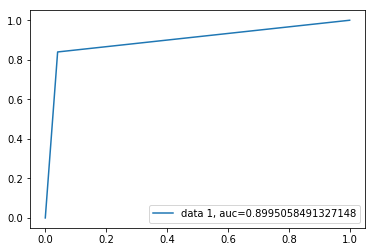

In [81]:
fpr, tpr, _ = metrics.roc_curve(expected,  predicted_VotingClassifier)
auc = metrics.roc_auc_score(expected, predicted_VotingClassifier)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# Взвешенное голосование 'soft'

0.996938775510204
0.996938775510204
[[441   3]
 [  0 536]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       444
           1       0.99      1.00      1.00       536

   micro avg       1.00      1.00      1.00       980
   macro avg       1.00      1.00      1.00       980
weighted avg       1.00      1.00      1.00       980

Точноть 0.996938775510204
Специфичность 0.9932432432432432
Чувствительность 1.0
--------------
f1ScoreWeighted= 0.9969378584701519
f1ScoreMacro= 0.9969097359085534
f1ScoreBinary= 0.9972093023255814


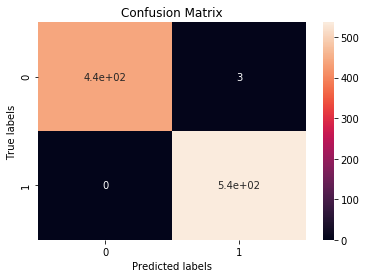

In [82]:
eclf2 = VotingClassifier(estimators=[('rdf_model',all_models['rdf_model']),
                                     ('nu_svc', all_models['nu_svc']),
                                     ('lgModel', all_models['lgModel']),
                                        ], 
                                     voting='soft')
eclf2 = eclf2.fit(normalized_train_dataset, train_target)

print(eclf2.score( normalized_train_dataset, train_target))

print(eclf2.score( normalized_test_dataset, test_target))

expected = test_target
predicted_VotingClassifier = eclf2.predict(normalized_test_dataset)

#---------------------------------------------------------------------
#Отрисовка confusion_matrix

cm = metrics.confusion_matrix(expected, predicted_VotingClassifier)
print(cm)
spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
buff_score=eclf2.score(normalized_test_dataset, test_target)
Score.append(buff_score)
print(metrics.classification_report(expected, predicted_VotingClassifier))
print('Точноть',buff_score)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')  

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');
#--------------------------------------------------------------------
#Результаты
f1ScoreWeighted=f1_score(test_target, predicted_VotingClassifier, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(test_target, predicted_VotingClassifier, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)
      
f1ScoreBinary=f1_score(test_target, predicted_VotingClassifier, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)

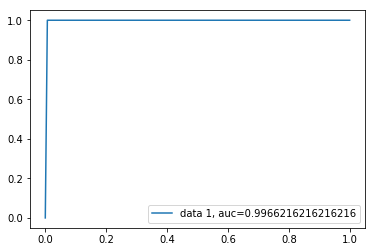

In [83]:
fpr, tpr, _ = metrics.roc_curve(expected,  predicted_VotingClassifier)
auc = metrics.roc_auc_score(expected, predicted_VotingClassifier)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()